In [1]:
from langchain_core.tools import tool

In [2]:
from langchain_openai import AzureOpenAIEmbeddings, AzureChatOpenAI 



embedding_function = AzureOpenAIEmbeddings(
    azure_endpoint="https://2000081253-openai.openai.azure.com/",
    api_key="107c20f6b6774c80b98c6f6a828f6374",
    azure_deployment="Text-embedding",
    api_version="2023-03-15-preview"
    )

llm = AzureChatOpenAI(
    api_key="107c20f6b6774c80b98c6f6a828f6374",
    azure_deployment="gpt-4",
    azure_endpoint="https://2000081253-openai.openai.azure.com/",
    api_version="2023-03-15-preview",
    temperature=0.8
)

In [3]:
db = 'C:\\Users\\2000081253\\Desktop\\Neuronex\\Draft_Folder\\NeuroNex_Database.db'

## Utility functions

We will define a few utility functions to help us with the agent implementation. Specifically, we will wrap a `ToolNode` with a fallback to handle errors and surface them to the agent.

In [4]:
from typing import Any

from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langgraph.prebuilt import ToolNode




def create_tool_node_with_fallback(tools: list) -> RunnableWithFallbacks[Any, dict]:
    """
    Create a ToolNode with a fallback to handle errors and surface them to the agent.
    """
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

In [5]:
from langchain_openai import AzureOpenAIEmbeddings, AzureChatOpenAI 



embedding_function = AzureOpenAIEmbeddings(
    azure_endpoint="https://2000081253-openai.openai.azure.com/",
    api_key="107c20f6b6774c80b98c6f6a828f6374",
    azure_deployment="Text-embedding",
    api_version="2023-03-15-preview"
    )

llm = AzureChatOpenAI(
    api_key="107c20f6b6774c80b98c6f6a828f6374",
    azure_deployment="gpt-4",
    azure_endpoint="https://2000081253-openai.openai.azure.com/",
    api_version="2023-03-15-preview",
    temperature=0.8
)

## Define tools for the agent

We will define a few tools that the agent will use to interact with the database.

1. `list_tables_tool`: Fetch the available tables from the database
2. `get_schema_tool`: Fetch the DDL for a table
3. `db_query_tool`: Execute the query and fetch the results OR return an error message if the query fails

For the first two tools, we will grab them from the `SQLDatabaseToolkit`, also available in the `langchain_community` package.

In [6]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_community.utilities import SQLDatabase

database = SQLDatabase.from_uri("sqlite:///NeuroNex_Database.db")
toolkit = SQLDatabaseToolkit(db=database, llm=llm)
tools = toolkit.get_tools()

list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")
get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")

print(list_tables_tool.invoke(""))

print(get_schema_tool.invoke("SalesOrderHeader"))

Address, Customer, CustomerAddress, Product, ProductCatagory, ProductDescription, ProductModel, ProductModelProductDescription, SalesOrderDetail, SalesOrderHeader

CREATE TABLE "SalesOrderHeader" (
	"SalesOrderID" INTEGER, 
	"RevisionNumber" INTEGER, 
	"OrderDate" TEXT, 
	"DueDate" TEXT, 
	"ShipDate" TEXT, 
	"Status" INTEGER, 
	"OnlineOrderFlag" INTEGER, 
	"SalesOrderNumber" TEXT, 
	"PurchaseOrderNumber" TEXT, 
	"AccountNumber" TEXT, 
	"CustomerID" INTEGER, 
	"ShipToAddressID" INTEGER, 
	"BillToAddressID" INTEGER, 
	"ShipMethod" TEXT, 
	"CreditCardApprovalCode" REAL, 
	"SubTotal" REAL, 
	"TaxAmt" REAL, 
	"Freight" REAL, 
	"TotalDue" REAL, 
	"Comment" REAL, 
	rowguid TEXT, 
	"ModifiedDate" TEXT
)

/*
3 rows from SalesOrderHeader table:
SalesOrderID	RevisionNumber	OrderDate	DueDate	ShipDate	Status	OnlineOrderFlag	SalesOrderNumber	PurchaseOrderNumber	AccountNumber	CustomerID	ShipToAddressID	BillToAddressID	ShipMethod	CreditCardApprovalCode	SubTotal	TaxAmt	Freight	TotalDue	Comment	rowguid	

The third will be defined manually. For the `db_query_tool`, we will execute the query against the database and return the results.

In [7]:
from langchain_core.tools import tool


@tool
def db_query_tool(query: str) -> str:
    """
    Execute a SQL query against the database and get back the result.
    If the query is not correct, an error message will be returned.
    If an error is returned, rewrite the query, check the query, and try again.
    """
    result = database.run_no_throw(query)
    if not result:
        return "Error: Query failed. Please rewrite your query and try again."
    return result


print(db_query_tool.invoke("SELECT * FROM Address LIMIT 10;"))

[(9, '8713 Yosemite Ct.', None, 'Bothell', 'Washington', 'United States', '98011', '268af621-76d7-4c78-9441-144fd139821a', '2006-07-01T00:00:00.0000000'), (11, '1318 Lasalle Street', None, 'Bothell', 'Washington', 'United States', '98011', '981b3303-aca2-49c7-9a96-fb670785b269', '2007-04-01T00:00:00.0000000'), (25, '9178 Jumping St.', None, 'Dallas', 'Texas', 'United States', '75201', 'c8df3bd9-48f0-4654-a8dd-14a67a84d3c6', '2006-09-01T00:00:00.0000000'), (28, '9228 Via Del Sol', None, 'Phoenix', 'Arizona', 'United States', '85004', '12ae5ee1-fc3e-468b-9b92-3b970b169774', '2005-09-01T00:00:00.0000000'), (32, '26910 Indela Road', None, 'Montreal', 'Quebec', 'Canada', 'H1Y 2H5', '84a95f62-3ae8-4e7e-bbd5-5a6f00cd982d', '2006-08-01T00:00:00.0000000'), (185, '2681 Eagle Peak', None, 'Bellevue', 'Washington', 'United States', '98004', '7bccf442-2268-46cc-8472-14c44c14e98c', '2006-09-01T00:00:00.0000000'), (297, '7943 Walnut Ave', None, 'Renton', 'Washington', 'United States', '98055', '52410

While not strictly a tool, we will prompt an LLM to check for common mistakes in the query and later add this as a node in the workflow.

In [8]:
from langchain_core.prompts import ChatPromptTemplate

query_check_system = """You are a SQL expert with a strong attention to detail.
Double check the SQLite query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

You will call the appropriate tool to execute the query after running this check."""

query_check_prompt = ChatPromptTemplate.from_messages(
    [("system", query_check_system), ("placeholder", "{messages}")]
)
query_check = query_check_prompt | llm.bind_tools(
    [db_query_tool], tool_choice="required"
)

query_check.invoke({"messages": [("user", "SELECT * FROM Address LIMIT 10;")]})

APIConnectionError: Connection error.

: 

## Define the workflow

We will then define the workflow for the agent. The agent will first force-call the `list_tables_tool` to fetch the available tables from the database, then follow the steps mentioned at the beginning of the tutorial.

In [27]:
from typing import Annotated, Literal

from langchain_core.messages import AIMessage
from langchain_openai import ChatOpenAI
# NOTE: you must use langchain-core >= 0.3 with Pydantic v2
from pydantic import BaseModel, Field
from typing_extensions import TypedDict

from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import AnyMessage, add_messages


# Define the state for the agent
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


# Define a new graph
workflow = StateGraph(State)


# Add a node for the first tool call
def first_tool_call(state: State) -> dict[str, list[AIMessage]]:
    return {
        "messages": [
            AIMessage(
                content="",
                tool_calls=[
                    {
                        "name": "sql_db_list_tables",
                        "args": {},
                        "id": "tool_abcd123",
                    }
                ],
            )
        ]
    }


def model_check_query(state: State) -> dict[str, list[AIMessage]]:
    """
    Use this tool to double-check if your query is correct before executing it.
    """
    return {"messages": [query_check.invoke({"messages": [state["messages"][-1]]})]}


workflow.add_node("first_tool_call", first_tool_call)

# Add nodes for the first two tools
workflow.add_node(
    "list_tables_tool", create_tool_node_with_fallback([list_tables_tool])
)
workflow.add_node("get_schema_tool", create_tool_node_with_fallback([get_schema_tool]))

# Add a node for a model to choose the relevant tables based on the question and available tables
model_get_schema = llm.bind_tools(
    [get_schema_tool]
)
workflow.add_node(
    "model_get_schema",
    lambda state: {
        "messages": [model_get_schema.invoke(state["messages"])],
    },
)


# Describe a tool to represent the end state
class SubmitFinalAnswer(BaseModel):
    """Submit the final answer to the user based on the query results."""

    final_answer: str = Field(..., description="The final answer to the user")


# Add a node for a model to generate a query based on the question and schema
query_gen_system = """You are a SQL expert with a strong attention to detail.

Given an input question, output a syntactically correct SQLite query to run, then look at the results of the query and return the answer.

DO NOT call any tool besides SubmitFinalAnswer to submit the final answer.

When generating the query:

Output the SQL query that answers the input question without a tool call.

Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.

If you get an error while executing a query, rewrite the query and try again.

If you get an empty result set, you should try to rewrite the query to get a non-empty result set. 
NEVER make stuff up if you don't have enough information to answer the query... just say you don't have enough information.

If you have enough information to answer the input question, simply invoke the appropriate tool to submit the final answer to the user.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database."""
query_gen_prompt = ChatPromptTemplate.from_messages(
    [("system", query_gen_system), ("placeholder", "{messages}")]
)
query_gen = query_gen_prompt | llm.bind_tools(
    [SubmitFinalAnswer]
)


def query_gen_node(state: State):
    message = query_gen.invoke(state)

    # Sometimes, the LLM will hallucinate and call the wrong tool. We need to catch this and return an error message.
    tool_messages = []
    if message.tool_calls:
        for tc in message.tool_calls:
            if tc["name"] != "SubmitFinalAnswer":
                tool_messages.append(
                    ToolMessage(
                        content=f"Error: The wrong tool was called: {tc['name']}. Please fix your mistakes. Remember to only call SubmitFinalAnswer to submit the final answer. Generated queries should be outputted WITHOUT a tool call.",
                        tool_call_id=tc["id"],
                    )
                )
    else:
        tool_messages = []
    return {"messages": [message] + tool_messages}


workflow.add_node("query_gen", query_gen_node)

# Add a node for the model to check the query before executing it
workflow.add_node("correct_query", model_check_query)

# Add node for executing the query
workflow.add_node("execute_query", create_tool_node_with_fallback([db_query_tool]))


# Define a conditional edge to decide whether to continue or end the workflow
def should_continue(state: State) -> Literal[END, "correct_query", "query_gen"]:
    messages = state["messages"]
    last_message = messages[-1]
    # If there is a tool call, then we finish
    if getattr(last_message, "tool_calls", None):
        return END
    if last_message.content.startswith("Error:"):
        return "query_gen"
    else:
        return "correct_query"


# Specify the edges between the nodes
workflow.add_edge(START, "first_tool_call")
workflow.add_edge("first_tool_call", "list_tables_tool")
workflow.add_edge("list_tables_tool", "model_get_schema")
workflow.add_edge("model_get_schema", "get_schema_tool")
workflow.add_edge("get_schema_tool", "query_gen")
workflow.add_conditional_edges(
    "query_gen",
    should_continue,
)
workflow.add_edge("correct_query", "execute_query")
workflow.add_edge("execute_query", "query_gen")

# Compile the workflow into a runnable
app = workflow.compile()

## Visualize the graph

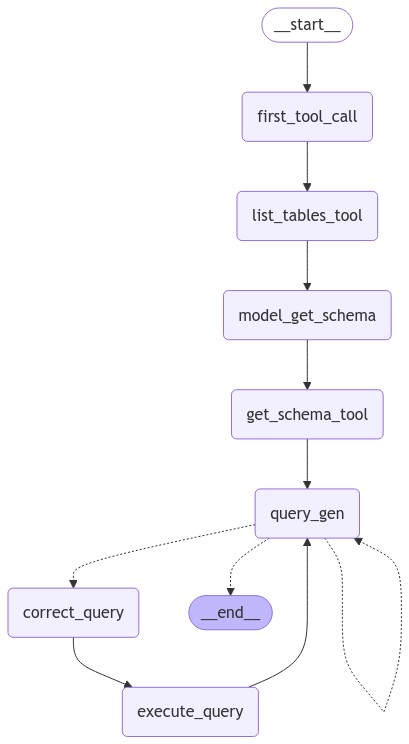

In [28]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

## Run the agent

In [29]:
@tool
def fetch_products_from_database(query: str):
    """
    fetch product details from the database using the user input message.
    This tool used when the user ask for the suggestion, product comparision and product details.

    Args:
        query (str): user input message

    """
    print(query)
    
    messages = app.invoke(
        {"messages": [("user", query)]}
    )
    json_str = messages["messages"][-1].tool_calls[0]["args"]["final_answer"]
    return json_str

In [30]:
import sqlite3 

def get_order_header(query):

    connection_obj = sqlite3.connect(db) 
    cursor_obj = connection_obj.cursor() 

    cursor_obj.execute(query) 

    columns = [description[0] for description in cursor_obj.description]
    result = []

    output = cursor_obj.fetchall()
    for row in output:
        rowdetail = {} 
        for i in range(len(row)):
            rowdetail[columns[i]] = row[i]
        result.append(rowdetail)

    connection_obj.commit() 
    connection_obj.close()
    return result

def execute_query(query):

    connection_obj = sqlite3.connect(db) 
    cursor_obj = connection_obj.cursor() 

    cursor_obj.execute(query) 

    columns = [description[0] for description in cursor_obj.description]
    result = []

    output = cursor_obj.fetchall()
    for row in output:
        output = [dict(zip(columns, row))]
        result.append(output[0])

    connection_obj.commit() 
    connection_obj.close()
    return result


def get_order_details(customer_id):

    final_result = {}

    salesorderheaderQuery = f"""SELECT *
                    FROM SalesOrderHeader
                    WHERE SalesOrderHeader.CustomerID = {customer_id};
                """
    salesorderheaders = get_order_header(salesorderheaderQuery)

    for salesorderheader in salesorderheaders:

        result = {}

        AddressQuery = f"""SELECT *
                        FROM Address
                        WHERE Address.AddressID = {salesorderheader["ShipToAddressID"]}
                    """
        address = execute_query(AddressQuery)

        SalesOrderDetailQuery = f"""SELECT *
                        FROM SalesOrderDetail
                        WHERE SalesOrderDetail.SalesOrderID = {salesorderheader["SalesOrderID"]}
                    """
        salesorderdetail = execute_query(SalesOrderDetailQuery)

        ListOfProducts = []

        for orders in salesorderdetail:

            

            ProductQuery = f"""SELECT ProductID, Name, ProductNumber, Color, StandardCost, ListPrice, Size, Weight
                            FROM Product
                            WHERE Product.ProductID = {orders["ProductID"]}
                        """
            product = execute_query(ProductQuery)
            ListOfProducts.extend(product)

        result["SalesOrderHeader"] = salesorderheader
        result["SalesOrderDetail"] = salesorderdetail
        result["Address"] = address
        result["Product"] = ListOfProducts

        final_result[salesorderheader["SalesOrderNumber"]] = result

    return final_result



In [31]:
import sqlite3
from datetime import date, datetime
from typing import Optional
import random

import pytz
from langchain_core.runnables import RunnableConfig

@tool
def fetch_user_order_information(config: RunnableConfig) -> list[dict]:
    """Fetch all orders of the user.

    Returns:
        A list of dictionaries where each dictionary contains the user's order details, 
        it contains order details, address details and product details.
    """

    configuration = config.get("configurable", {})
    customer_id = configuration.get("customer_id", None)
    if not customer_id:
        raise ValueError("No Customer ID configured.")
    
    return get_order_details(customer_id)                                                                                           


@tool
def update_order_quantity(
    SalesOrderID: int,
    SalesOrderDetailID: int,
    LineTotal: float,
    OrderQty: int,
    TotalDue: float,
    TaxAmt: float,
    SubTotal: float,
) -> str:

    """
    Update a quantity of product.

    Args:
        SalesOrderID (int): The SalesOrderID value from the SalesOrderHeader Table.
        SalesOrderDetailID (int): The SalesOrderDetailID from the SalesOrderDetail Table.
        LineTotal (float): The Updated Line Total based on the Order Quantity for the SalesOrderDetail Table.
        OrderQty (int): The Updated Order Quantity.
        TotalDue (float): Based on the quantity TotalDue amount.
        TaxAmt (float): Based on the quantity Tax Amount.
        SubTotal (float): Based on the quantity SubTotal Amount.

    Returns:
        str: A message indicating whether the Quantity successfully updated or not.

    """

    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = f"""
        UPDATE SalesOrderDetail 
        SET OrderQty = {OrderQty}, LineTotal = {LineTotal} 
        WHERE SalesOrderDetailID = {SalesOrderDetailID};
    """
    cursor.execute(query)

    query2 = f"""
        UPDATE SalesOrderHeader 
        SET TotalDue = {TotalDue}, TaxAmt = {TaxAmt}, SubTotal = {SubTotal} 
        WHERE SalesOrderID = {SalesOrderID}
    """
    cursor.execute(query2)

    conn.commit()

    cursor.close()
    conn.close()
    return "Quantity and the related details are successfully updated."



@tool
def update_shipping_address(
    SalesOrderNumber: str, 
    AddressLine1: str,
    AddressLine2: str,
    City: str,
    StateProvince: str,
    CountryRegion: str,
    PostalCode: str,
    config: RunnableConfig
) -> str:
    """
    Update a new the shipping adderess.

    Args:
        SalesOrderNumber (str): The SalesOrderNumber value from the SalesOrderHeader Table.
        AddressLine1 (str): The DoorNumber and Appartment name or street name of Address.
        AddressLine2 (str): The place name or Town name of the Address.
        City (str): The City Name of the Address.
        StateProvince (str): The State of the Address.
        PostalCode (str): The Postal Code of the Address(6 digit Number)

    Returns:
        str: A message indicating whether the Shippping Address successfully updated or not.
    """
    AddressID = random.randint(10000, 99999)

    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = f"""
    INSERT INTO Address (AddressLine1, AddressLine2, City, StateProvince, CountryRegion, PostalCode, AddressID)
    VALUES ('{AddressLine1}', '{AddressLine2}', '{City}', '{StateProvince}', '{CountryRegion}', '{PostalCode}', '{AddressID}');
    """
    cursor.execute(query)

    query = f"""UPDATE SalesOrderHeader SET ShipToAddressID = {AddressID} WHERE SalesOrderNumber = '{SalesOrderNumber}'"""
    cursor.execute(query)

    conn.commit()

    cursor.close()
    conn.close()
    return "Shipping Address Updated Successfully."


@tool
def cancel_order(SalesOrderNumber: str, *, config: RunnableConfig) -> str:
    """Cancel the user's order.
    
    Args:
        SalesOrderNumber: str: The SalesOrderNumber value from the SalesOrderHeader Table.
    """

    configuration = config.get("configurable", {})
    customer_id = configuration.get("customer_id", None)
    if not customer_id:
        raise ValueError("No passenger ID configured.")

    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = f"""SELECT Status, CustomerID FROM SalesOrderHeader WHERE SalesOrderNumber = '{SalesOrderNumber}'"""

    cursor.execute(query)
    existing_order = cursor.fetchone()

    column_names = [column[0] for column in cursor.description]
    results = [dict(zip(column_names, existing_order))]

    if not results:
        cursor.close()
        conn.close()
        return "No existing order found for the given sales order number."

    if(results[0]["Status"] == "Cancelled"):
        return "Order already in the cancel state."
    
    if(results[0]["CustomerID"] != customer_id):
        return f"This order ordered by someone else."

    query = f"""UPDATE SalesOrderHeader SET Status='Cancelled' WHERE SalesOrderNumber = '{SalesOrderNumber}'"""
    cursor.execute(query)
    conn.commit()

    cursor.close()
    conn.close()
    return "order successfully cancelled."


#### Utilities

Define helper functions to pretty print the messages in the graph while we debug it and to give our tool node error handling (by adding the error to the chat history).

In [32]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda

from langgraph.prebuilt import ToolNode


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def _print_event(event: dict, _printed: set):
    # print(event)
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            # print(message)
            if message.content != '':
                msg_repr = message.pretty_repr(html=True)
                print(msg_repr)
                _printed.add(message.id)


## Part 3: Conditional Interrupt

In this section, we'll refine our interrupt strategy by categorizing tools as safe (read-only) or sensitive (data-modifying). We'll apply interrupts to the sensitive tools only, allowing the bot to handle simple queries autonomously.

This balances user control and conversational flow, but as we add more tools, our single graph may grow too complex for this "flat" structure. We'll address that in the next section. 

Your graph for Part 3 will look something like the following diagram.

<img src="./img/part-3-diagram.png" src="../img/part-3-diagram.png">

#### State

As always, start by defining the graph state. Our state and LLM calling **are identical to** part 2. 


In [33]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_info: str


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant for Ecommerce Application. "
            " Use the provided tools to search for orders and other information to assist the user's queries. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            " If user missed any mandatory parameter ask user"
            "\n\nCurrent user:\n<User>\n{user_info}\n</User>"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())


# "Read"-only tools (such as retrievers) don't need a user confirmation to use
part_3_safe_tools = [
    fetch_user_order_information,
    fetch_products_from_database
]

# These tools all change the user's reservations.
# The user has the right to control what decisions are made
part_3_sensitive_tools = [
    cancel_order,
    update_shipping_address,
    update_order_quantity,
]
sensitive_tool_names = {t.name for t in part_3_sensitive_tools}
# Our LLM doesn't have to know which nodes it has to route to. In its 'mind', it's just invoking functions.
part_3_assistant_runnable = assistant_prompt | llm.bind_tools(
    part_3_safe_tools + part_3_sensitive_tools
)

#### Define Graph

Now, create the graph. Our graph is almost identical to part 2 **except** we split out the tools into 2 separate nodes. We only interrupt before the tools that are actually making changes to the user's bookings.

In [34]:
from typing import Literal

from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import tools_condition
from langgraph.graph import END, StateGraph, START

builder = StateGraph(State)


def user_info(state: State):
    return {"user_info": fetch_user_order_information.invoke({})}


# NEW: The fetch_user_info node runs first, meaning our assistant can see the user's flight information without
# having to take an action
builder.add_node("fetch_user_info", user_info)
builder.add_edge(START, "fetch_user_info")
builder.add_node("assistant", Assistant(part_3_assistant_runnable))
builder.add_node("safe_tools", create_tool_node_with_fallback(part_3_safe_tools))
builder.add_node(
    "sensitive_tools", create_tool_node_with_fallback(part_3_sensitive_tools)
)
# Define logic
builder.add_edge("fetch_user_info", "assistant")


def route_tools(state: State) -> Literal["safe_tools", "sensitive_tools", "__end__"]:
    next_node = tools_condition(state)
    # If no tools are invoked, return to the user
    if next_node == END:
        return END
    ai_message = state["messages"][-1]
    # This assumes single tool calls. To handle parallel tool calling, you'd want to
    # use an ANY condition
    first_tool_call = ai_message.tool_calls[0]
    if first_tool_call["name"] in sensitive_tool_names:
        return "sensitive_tools"
    return "safe_tools"


builder.add_conditional_edges(
    "assistant",
    route_tools,
)
builder.add_edge("safe_tools", "assistant")
builder.add_edge("sensitive_tools", "assistant")

memory = MemorySaver()
part_3_graph = builder.compile(
    checkpointer=memory,
    # NEW: The graph will always halt before executing the "tools" node.
    # The user can approve or reject (or even alter the request) before
    # the assistant continues
    interrupt_before=["sensitive_tools"],
)

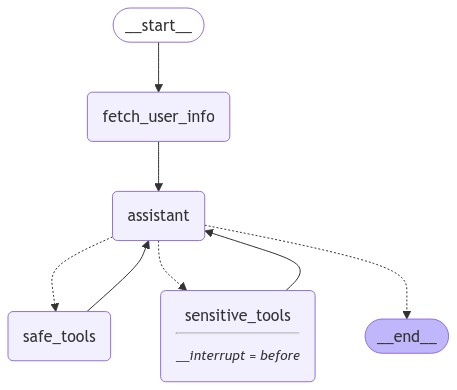

In [35]:
from IPython.display import Image, display

try:
    display(Image(part_3_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

#### Example Conversation

Now it's time to try out our newly revised chatbot! Let's run it over the following list of dialog turns. This time, we'll have many fewer confirmations.

In [36]:
import shutil
import uuid

thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The customer_id is used in our flight tools to
        # fetch the user's flight information
        "customer_id": 30072,
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

tutorial_questions = [
    "Hi",
    "Show my orders",
    "show me the rear brakes with low price"
]


_printed = set()
# We can reuse the tutorial questions from part 1 to see how it does.


while True:
    question = input()
    if(question == 'bye'):
        break
    events = part_3_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    
    for event in events:
        _print_event(event, _printed)
    snapshot = part_3_graph.get_state(config)
    while snapshot.next:
        # We have an interrupt! The agent is trying to use a tool, and the user can approve or deny it
        # Note: This code is all outside of your graph. Typically, you would stream the output to a UI.
        # Then, you would have the frontend trigger a new run via an API call when the user has provided input.
        user_input = input(
            "Do you approve of the above actions? Type 'y' to continue;"
            " otherwise, explain your requested changed.\n\n"
        )
        if user_input.strip() == "y":
            # Just continue
            result = part_3_graph.invoke(
                None,
                config,
            )
            _print_event(result, _printed)
        else:
            # Satisfy the tool invocation by
            # providing instructions on the requested changes / change of mind
            result = part_3_graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",
                        )
                    ]
                },
                config,
            )
        snapshot = part_3_graph.get_state(config)



# for question in tutorial_questions:
#     events = part_3_graph.stream(
#         {"messages": ("user", question)}, config, stream_mode="values"
#     )
#     for event in events:
#         _print_event(event, _printed)
#     snapshot = part_3_graph.get_state(config)
#     while snapshot.next:
#         # We have an interrupt! The agent is trying to use a tool, and the user can approve or deny it
#         # Note: This code is all outside of your graph. Typically, you would stream the output to a UI.
#         # Then, you would have the frontend trigger a new run via an API call when the user has provided input.
#         user_input = input(
#             "Do you approve of the above actions? Type 'y' to continue;"
#             " otherwise, explain your requested changed.\n\n"
#         )
#         if user_input.strip() == "y":
#             # Just continue
#             result = part_3_graph.invoke(
#                 None,
#                 config,
#             )
#         else:
#             # Satisfy the tool invocation by
#             # providing instructions on the requested changes / change of mind
#             result = part_3_graph.invoke(
#                 {
#                     "messages": [
#                         ToolMessage(
#                             tool_call_id=event["messages"][-1].tool_calls[0]["id"],
#                             content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",
#                         )
#                     ]
#                 },
#                 config,
#             )
#         snapshot = part_3_graph.get_state(config)

================================ Human Message =================================

Hi
================================== Ai Message ==================================

Hello! How can I assist you today?
================================ Human Message =================================

SHow my order details
================================== Ai Message ==================================

Sure! Here are the details for your order with Sales Order Number **SO71776**:

### Sales Order Information:
- **Sales Order ID:** 71776
- **Revision Number:** 2
- **Order Date:** 2008-06-01
- **Due Date:** 2008-06-13
- **Ship Date:** 2008-06-08
- **Status:** 5
- **Online Order Flag:** 0
- **Sales Order Number:** SO71776
- **Purchase Order Number:** PO19952192051
- **Account Number:** 10-4020-000106
- **Customer ID:** 30072
- **Ship To Address ID:** 80782
- **Bill To Address ID:** 640
- **Ship Method:** CARGO TRANSPORT 5
- **SubTotal:** 383.4
- **Tax Amount:** 31.635
- **Freight:** 1.9703
- **Total Due:**